# Detection and Quantification of Microspots

---

**Updated on:** 2023-09-11

> Authors: Simon Knoblauch (simon.knoblauch@student.uni-tuebingen.de)  
> Input file format: .tif, .png, .jpg
> Output file formats: None currently  
> Dependencies: imageio, pandas, numpy, skimage, matplotlib, ipympl  

**Please read the comments before proceeding to run the code and let us know if you run into any errors or find undocumented pieces of code.**

In [1]:
# Importing dependencies
import imageio.v3 as iio
import pandas as pd
import skimage
import matplotlib.pyplot as plt
import numpy as np
import ipympl
%matplotlib widget

## User Input

In [2]:
inputfile=r"test_images\halo_spots_1.tif"

first_spot="A1"
last_spot="L10"

### Extracting Information from User Input

In [3]:
row_conv={"abcdefghijklmnopqrstuvwxyz"[i-1]: i for i in range(1,27)}

firstrow_nr=row_conv[first_spot[0].lower()]
lastrow_nr=row_conv[last_spot[0].lower()]
rowcount=lastrow_nr-firstrow_nr+1


firstcol_nr=int(first_spot[1:])
lastcol_nr=int(last_spot[1:])
colcount=lastcol_nr-firstcol_nr+1

## Loading the Image File

[Text(0.5, 1.0, 'Grayscale Image')]

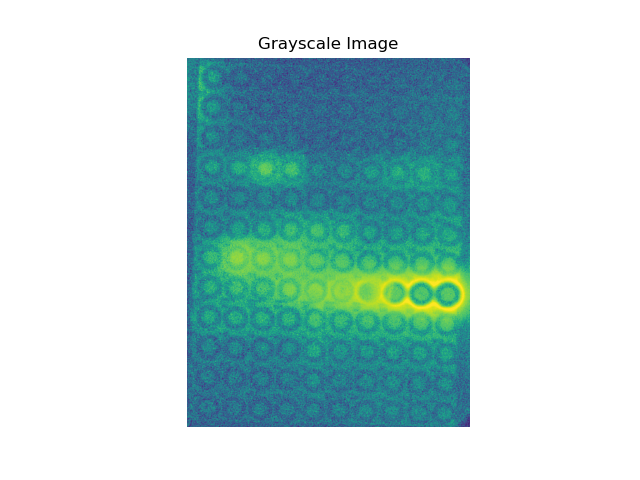

In [4]:
load=iio.imread(inputfile)

# Check if image has an alpha value and convert image to RGB.
if load.shape[2]==4:
    raw_img=skimage.color.rgb2gray(load[:,:,0:3])

# Convert RGB images to grayscale.
elif load.shape[2]==3:
    raw_img=skimage.color.rgb2gray(load)

# Invert the intensity values. Comment out if you do not wish to invert the image.
raw_img=skimage.util.invert(raw_img)

# Display the grayscale image using the "viridis" colormap.
fig,ax=plt.subplots()
ax.imshow(raw_img)
ax.axis("off")
ax.set(title="Grayscale Image")


## Inital Spot Detection

,x_coord,y_coord,radius,hough_peak_int
0,396,659,21,0.664062
1,484,1237,21,0.632812
2,391,891,21,0.625000
3,401,430,23,0.610294
4,102,191,20,0.591667
5,587,1011,21,0.585938
6,85,994,21,0.585938
7,898,791,22,0.585938
8,799,788,21,0.585938
9,189,885,20,0.575000


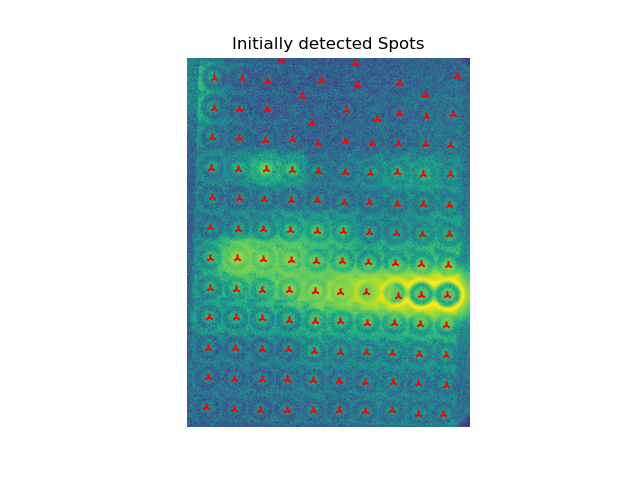

In [5]:
# Define the total number of expected spots:
spotnumber=120

# Edge detection in Image using the Canny method.
histeq_img=skimage.filters.rank.equalize(skimage.util.img_as_ubyte(raw_img),skimage.morphology.disk(50))
edges=skimage.feature.canny(
    image=histeq_img,
    sigma=10,
    low_threshold=0.001,
    high_threshold=0.001
    )

# Range of Radii that are tested during inital spotdetection.
tested_radii=np.arange(20,31)

# Hough transform for a circle of the edge-image and peak detection to find circles in earlier defined range of radii.
spot_hough=skimage.transform.hough_circle(edges,tested_radii)
accums,spot_x,spot_y,spot_rad=skimage.transform.hough_circle_peaks(
    hspaces=spot_hough,
    radii=tested_radii,
    total_num_peaks=spotnumber,
    min_xdistance=70,
    min_ydistance=70,
    threshold=0.3*spot_hough.max()
    )

# Storing results in DataFrame.
det_spot=pd.DataFrame({"x_coord":spot_x,"y_coord":spot_y,"radius":spot_rad,"hough_peak_int":accums})

# Displaying image with initally detected spots.
fig,ax=plt.subplots()
ax.imshow(raw_img)
ax.axis("off")
ax.set(title="Initially detected Spots")
ax.scatter(spot_x,spot_y,marker="2",c="red")

# Displaying the first 10 Rows of the Dataframe.
det_spot.head(10)

## Grid Detection

[Text(0.5, 1.0, 'Detected Spot-Grid')]

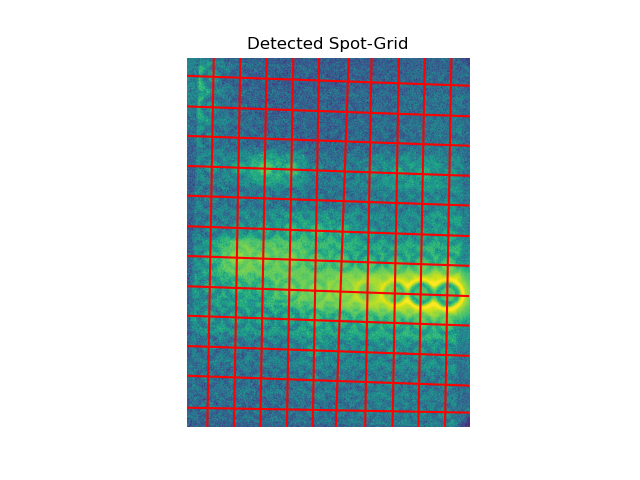

In [6]:
def draw_spot(image,x_coord,y_coord,radius,value):
    rr,cc=skimage.draw.disk((y_coord,x_coord),radius)
    try:
        image[rr,cc]=value
    except:
        print(f"Spot at Coordinates ({x_coord}, {y_coord}) could not be drawn: Out of Bounds.")
    return image

def detect_gridlines(img,max_tilt):
    line_img,ang,dist=skimage.transform.hough_line(img)
    line_img[:,np.r_[max_tilt:89-max_tilt,91+max_tilt:180-max_tilt]]=0
    accum,angle,distance=skimage.transform.hough_line_peaks(line_img,ang,dist,min_distance=80,threshold=0.2*line_img.max())
    return angle,distance

class line:
    def __init__(self, angle, distance):
        self.dist=distance
        self.angle=angle
        self.slope=np.tan(angle+np.pi/2)
        (x0, y0)=distance*np.array([np.cos(angle),np.sin(angle)])
        self.y_int=y0-self.slope*x0
    
    def __repr__(self):
        return f"y={self.slope:.2f}*x+{self.y_int:.2f}"

    def intersect(self,line2):
        x=(line2.y_int-self.y_int)/(self.slope-line2.slope)
        y=self.slope*x+self.y_int
        return x,y

# Define the maximum allowed tilt of the Grid.
max_allowed_tilt=5

# Create an empty image and draw a dot for each detected spot.
dot_img=np.zeros(raw_img.shape)
for idx in det_spot.index:
    dot_img=draw_spot(dot_img,det_spot.loc[idx,"x_coord"],det_spot.loc[idx,"y_coord"],5,255)

# Detect lines laying on the 
angle, dist=detect_gridlines(dot_img, max_tilt=max_allowed_tilt)

# Create a List of vertical and horizontal line objects.
hor_line=[line(a,d) for a,d in zip(angle,dist) if np.abs(np.rad2deg(a))<=max_allowed_tilt]
vert_line=[line(a,d) for a,d in zip(angle,dist) if np.abs(np.rad2deg(a))>=90-max_allowed_tilt]

# Calculation of the coordinates of all gridline-intersections.
intersections=[]
for h_l in hor_line:
    for v_l in vert_line:
        intersections.append(v_l.intersect(h_l))

# Display the grid.
fig,ax=plt.subplots()
ax.imshow(raw_img)
for item in hor_line+vert_line:
    ax.axline((0,item.y_int), slope=item.slope,c="r")
ax.set(ylim=[raw_img.shape[0],0],xlim=[0,raw_img.shape[1]])
ax.axis("off")
ax.set(title="Detected Spot-Grid")

## Spot Correction

,x_coord,y_coord,radius,hough_peak_int,min_griddist,note
0,396,659,21,0.664062,1.352589,kept
1,484,1237,21,0.632812,1.521144,kept
2,391,891,21,0.625000,1.701516,kept
3,401,430,23,0.610294,0.872339,kept
4,102,191,20,0.591667,2.346345,kept
...,...,...,...,...,...,...
115,910,101,21,NaN,0,backfilled
116,797,904,21,NaN,0,backfilled
117,704,211,21,NaN,0,backfilled
118,706,94,21,NaN,0,backfilled


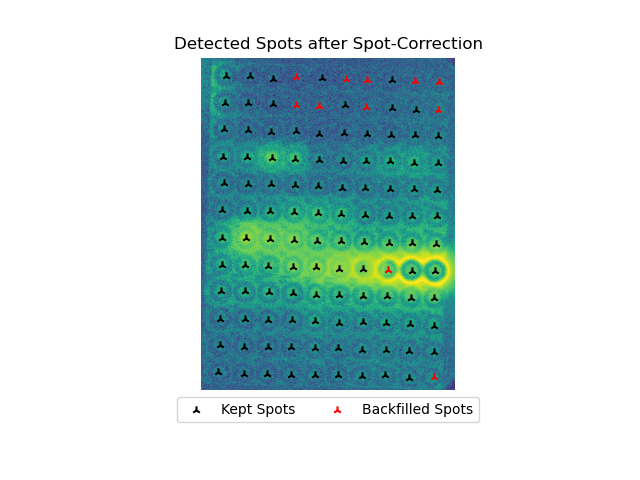

In [7]:
# Add relevant columns to spot-dataframe for spot correction.
det_spot["min_griddist"]=10000 # Placeholder value to be replaced
det_spot["note"]="kept"

#Loop over all gridpoints and detected spots:
for gridpoint in intersections:
    dist_list=[]
    for idx in det_spot.index:
        spot=det_spot.loc[idx]
        # Calculate the distance between a gridpoint and a spot.
        pointdist=np.linalg.norm(np.array(gridpoint)-np.array((spot["x_coord"],spot["y_coord"])))
        # Append to distance list needed later.
        dist_list.append(pointdist)

        # Add the distance of the specific spot to the current gridpoint if it is smaller than all previously tested gridpoints.
        if pointdist<spot["min_griddist"]: det_spot.loc[idx,"min_griddist"]=pointdist

    # If the minimum distance of a gridpoint to all detected spots is greater than 10, no spot was determined for this gridpoint with reasonable accuracy.
    if min(dist_list)>10:
        # Backfilling spot at the location of the gridpoint
        new_spot=pd.Series({"x_coord":int(gridpoint[0]),"y_coord":int(gridpoint[1]),"radius":int(spot_rad.mean()),"min_griddist":0,"note":"backfilled"})
        det_spot=pd.concat([det_spot,new_spot.to_frame().T],ignore_index=True)

# If the minimum distance of an initally detected spot to all gridpoints is greater than 10, it probably was falsely detected as a spot. --> Removal of the spot.
corr_spot=det_spot[det_spot["min_griddist"]<10].reset_index(drop=True).copy()

fig,ax=plt.subplots()
ax.imshow(raw_img)
ax.scatter(corr_spot.loc[corr_spot["note"]=="kept","x_coord"],corr_spot.loc[corr_spot["note"]=="kept","y_coord"],marker="2",c="k",label="Kept Spots")
ax.scatter(corr_spot.loc[corr_spot["note"]=="backfilled","x_coord"],corr_spot.loc[corr_spot["note"]=="backfilled","y_coord"],marker="2",c="r",label="Backfilled Spots")
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 0),
          fancybox=True,ncol=5)
ax.axis("off")
ax.set(title="Detected Spots after Spot-Correction")
corr_spot

## Halo Detection

[Text(0.5, 1.0, 'Detected Halos with corresponding Radius')]

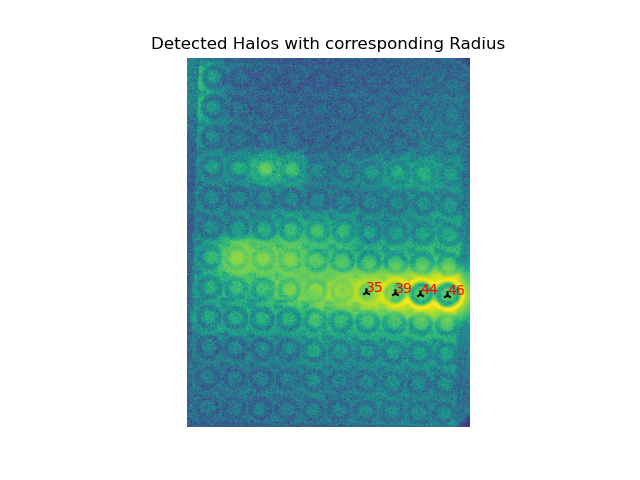

In [8]:
# Create a mask of the image only containing halos.
halo_mask=raw_img<skimage.filters.threshold_yen(raw_img)

# Applying the mask to the histeq_img yields more consistent results for circle detection. The mask itself yields better results when calculated from the raw image.
halo_img=histeq_img.copy()
halo_img[halo_mask]=0

# Canny edge detection and follow up circle detection using hough transform.
halo_edge=skimage.feature.canny(halo_img,10,10,60)
halo_radii=np.arange(35,70) # Radii tested for.
halo_hough=skimage.transform.hough_circle(halo_edge,halo_radii)

h_accum,h_x,h_y,h_radii=skimage.transform.hough_circle_peaks(
    halo_hough,
    halo_radii,
    min_xdistance=70,
    min_ydistance=70,
    threshold=0.5*halo_hough.max()
    )

# Saving all detected halos in a Dataframe
ab_halo=pd.DataFrame({"x_coord":h_x,"y_coord":h_y,"radius":h_radii})

# Displaying all detected Halos with their respective radii.
fig,ax=plt.subplots()
ax.imshow(raw_img)
ax.scatter(h_x,h_y,marker="2",c="k")
for x,y,rad in zip(h_x,h_y,h_radii):
    ax.text(x, y, f'{rad}',c="r")
ax.axis("off")
ax.set(title="Detected Halos with corresponding Radius")

## Halo Assignment

In [9]:
# Create a new column for halos in spot DataFrame
corr_spot["halo_rad"]=np.nan

# Loop over all detected halos and all spots
for h_idx in ab_halo.index:
    # Exctract halo coordinates
    h_coord=np.array((ab_halo.loc[h_idx,"x_coord"],ab_halo.loc[h_idx,"y_coord"]))
    
    for s_idx in corr_spot.index:
        # Extract spot coordinates
        s_coord=np.array((corr_spot.loc[s_idx,"x_coord"],corr_spot.loc[s_idx,"y_coord"]))
        
        # If the distance between the current halo and the current spot is below a threshold, the halo is considered part of the spot.
        if np.linalg.norm(h_coord-s_coord)< 10:
            corr_spot.loc[s_idx,"halo_rad"]=ab_halo.loc[h_idx,"radius"]

corr_spot

,x_coord,y_coord,radius,hough_peak_int,min_griddist,note,halo_rad
0,396,659,21,0.664062,1.352589,kept,NaN
1,484,1237,21,0.632812,1.521144,kept,NaN
2,391,891,21,0.625000,1.701516,kept,NaN
3,401,430,23,0.610294,0.872339,kept,NaN
4,102,191,20,0.591667,2.346345,kept,NaN
...,...,...,...,...,...,...,...
115,910,101,21,NaN,0,backfilled,NaN
116,797,904,21,NaN,0,backfilled,39.0
117,704,211,21,NaN,0,backfilled,NaN
118,706,94,21,NaN,0,backfilled,NaN


## Spot Sorting

In [10]:
# Calculation of Sum and Difference of x and y coordinates for every spot. Required to find the top left and top right spots in the DataFrame.
corr_spot["x+y"]=corr_spot["x_coord"]+corr_spot["y_coord"]
corr_spot["x-y"]=corr_spot["x_coord"]-corr_spot["y_coord"]

#col=["row","column","x_coord","y_coord","radius","note"]
sort_spot=pd.DataFrame(columns=["row_letter","row","column"])

# Loop Through the algorithm until all spots have been sorted:
row_nr=firstrow_nr
while len(corr_spot)>0:
    # Empty DataFrame for spots of the current top row.
    spotrow=pd.DataFrame()
    
    # The top left spot must have the lowest sum of x and y coordinate.
    idx_topleft=corr_spot["x+y"].sort_values().index[0]
    topleft_coord=np.array((corr_spot.loc[idx_topleft,"x_coord"],corr_spot.loc[idx_topleft,"y_coord"]))
    
    # The top right spot must have the highest difference between the x and y coordinate.
    idx_topright=corr_spot["x-y"].sort_values().index[-1]
    topright_coord=np.array((corr_spot.loc[idx_topright,"x_coord"],corr_spot.loc[idx_topright,"y_coord"]))

    # Loop through all spot in the DataFrame
    col_nr=firstcol_nr
    for idx in corr_spot.index:
        # Extract coordinates of current spot
        spot=corr_spot.loc[idx]
        spot_coord=np.array((spot["x_coord"],spot["y_coord"]))

        # Calculate the distance of the current spot to a line that goes through the left most and right most spot of the current row
        row_dist=np.linalg.norm(np.cross(np.subtract(spot_coord,topleft_coord),np.subtract(topright_coord,topleft_coord))/np.linalg.norm(np.subtract(topright_coord,topleft_coord)))

        # If the distance between the spot and the line is smaller than the spots radius, the spot must lie within the row
        if row_dist<=spot["radius"]:
            # Add spot to current row and remove it from the DataFrame of unsorted spots
            spotrow=pd.concat([spotrow,spot.to_frame().T])
            corr_spot.drop(idx, inplace=True)
            col_nr+=1
    
    # Sort spots in current row from left to right and add row + column index.
    spotrow.sort_values("x_coord",ascending=True,inplace=True)
    spotrow["row"]=row_nr
    spotrow["row_letter"]={v:k for k,v in row_conv.items()}[row_nr].upper()
    spotrow["column"]=range(1,col_nr)

    # Add row to the DataFrame of sorted spots
    sort_spot=pd.concat([sort_spot,spotrow],ignore_index=True)

    row_nr+=1
    if row_nr>1000: break # Break the loop if not all spots can be assigned to a row.

sort_spot

,row_letter,row,column,x_coord,y_coord,radius,hough_peak_int,min_griddist,note,halo_rad,x+y,x-y
0,A,1,1,104,76,20,0.55,3.306218,kept,NaN,180,28
1,A,1,2,209,78,21,0.296875,5.382195,kept,NaN,287,131
2,A,1,3,307,89,25,0.319444,8.647855,kept,NaN,396,218
3,A,1,4,406,84,21,NaN,0,backfilled,NaN,490,322
4,A,1,5,514,87,20,0.308333,8.482186,kept,NaN,601,427
...,...,...,...,...,...,...,...,...,...,...,...,...
115,L,12,6,581,1351,23,0.419118,7.934894,kept,NaN,1932,-770
116,L,12,7,684,1356,20,0.4,1.907174,kept,NaN,2040,-672
117,L,12,8,784,1352,22,0.335938,6.755226,kept,NaN,2136,-568
118,L,12,9,886,1364,23,0.367647,6.744617,kept,NaN,2250,-478


## Determination of Spot-Intensities

column,1,2,3,4,5,6,7,8,9,10
row_letter,,,,,,,,,,
A,0.526767,0.373394,0.336259,0.328327,0.326783,0.332705,0.336099,0.360865,0.362411,0.380998
B,0.510586,0.379168,0.358313,0.361051,0.357192,0.365445,0.368880,0.388114,0.399004,0.423691
C,0.465846,0.391353,0.392648,0.383340,0.347541,0.364199,0.373810,0.381342,0.425841,0.457264
D,0.548991,0.603657,0.741077,0.680759,0.470318,0.460836,0.535677,0.592593,0.621267,0.546427
E,0.471958,0.451281,0.462143,0.467447,0.447190,0.445305,0.456217,0.473308,0.507208,0.522399
F,0.493384,0.553270,0.602932,0.665380,0.688551,0.648606,0.567551,0.547640,0.575291,0.586748
G,0.650687,0.824804,0.806083,0.795082,0.739619,0.724367,0.696261,0.717007,0.732283,0.753454
H,0.614914,0.672140,0.686064,0.784310,0.810225,0.827774,0.788468,0.762924,0.722484,0.735414
I,0.581901,0.599477,0.616462,0.623083,0.688721,0.657617,0.683476,0.695548,0.720474,0.738514


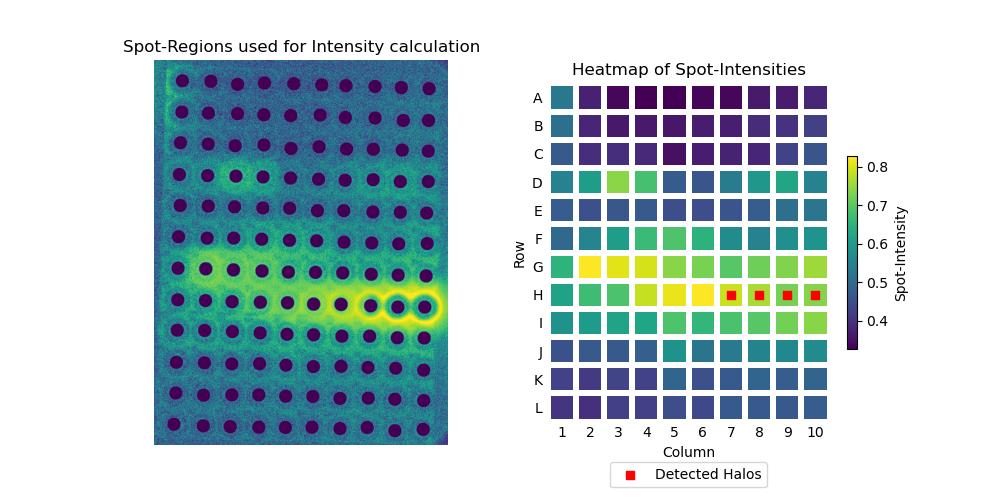

In [11]:
spot_img=raw_img.copy()
sort_spot["spot_intensity"]=np.nan

# Looping through all spots.
for idx in sort_spot.index:
    # Try to extract all pixel indices of the current spot, otherwise print an error.
    try:
        # Indices of all pixels part of the current spot
        rr,cc=skimage.draw.disk((sort_spot.loc[idx,"y_coord"],sort_spot.loc[idx,"x_coord"]),25)
        # Mean intensity of all pixels within the spot
        sort_spot.loc[idx,"spot_intensity"]=raw_img[rr,cc].sum()/len(rr)
        # Creating an image with all spots Highlighted
        spot_img[rr,cc]=0
    
    except:
        print(f"Spot at Coordinates ({sort_spot.loc[idx,'x_coord']}, {sort_spot.loc[idx,'y_coord']}) could not be drawn: Out of Bounds.")

# Create a heatmap of all spots of the current image
heatmap=sort_spot.pivot_table(index="row_letter",columns="column",values="spot_intensity")

# Display Image and corresponding Heatmap
fig,ax=plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(spot_img)
ax[0].axis("off")
ax[0].set(title="Spot-Regions used for Intensity calculation")

htmp=ax[1].pcolormesh(heatmap.iloc[::-1],edgecolors="white",linewidth=4)
ax[1].set(title="Heatmap of Spot-Intensities",
          aspect="equal",
          ylabel="Row",
          xlabel="Column",
          yticks=np.array(range(1,len(heatmap)+1))-0.5,
          xticks=np.array(range(1,len(heatmap.columns)+1))-0.5,
          yticklabels=heatmap.index[::-1],
          xticklabels=heatmap.columns
          )
ax[1].spines[["right","left","top","bottom"]].set_visible(False)
ax[1].tick_params(axis=u'both', which=u'both',length=0)
ax[1].scatter(sort_spot.loc[sort_spot["halo_rad"]>0,"column"]-0.5,col_nr+1.5-sort_spot.loc[sort_spot["halo_rad"]>0,"row"],marker="s", c="red",label="Detected Halos")
box = ax[1].get_position()
ax[1].set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
ax[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True,ncol=5)
fig.colorbar(htmp,ax=ax[1],label="Spot-Intensity",shrink=0.5)
heatmap

## Save Results

In [12]:
# Write a csv-file of the results.
sort_spot.to_csv(r"output\spot_table.csv")